In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model, load_model
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.utils import plot_model
from scipy.spatial import distance
from scipy.spatial.distance import cdist, cosine
import matplotlib.pyplot as plt
from tensorboard.plugins import projector
import joblib

2023-02-23 17:07:26.931575: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 17:07:29.308676: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-23 17:07:33.128380: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-23 17:07:33.128631: W tensorfl

In [2]:
columns = ['season', 'overall', 'potential', 
           #'age', 'height_cm', 'weight_kg', 'league_level', 
           'height_cm', 'weight_kg',
           'skill_moves', #'international_reputation', 
           'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 
           'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 
           'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 
           'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 
           'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 
           'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 
           'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 
           'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 
           'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 
           'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 
           #### Traits
           'One Club Player', 'Avoids Using Weaker Foot', 'Playmaker', 'Dives Into Tackles', 'Finesse Shot', 
           'Power Free-Kick', 'Leadership', 'Power Header', 'Technical Dribbler', 'Early Crosser', 'Takes Finesse Free Kicks', 
           'Through Ball', 'Giant Throw-in', 'Beat Offside Trap', 'Outside Foot Shot', 'Long Passer', 'Set Play Specialist', 'Chip Shot', 
           'Diver', 'Team Player', 'Injury Free', 'Injury Prone', 'Swerve Pass', 'Solid Player', 'Selfish', 'Speed Dribbler', 'Flair', 
           'Long Shot Taker', 'Long Throw-in', 'Backs Into Player', 'Target Forward', 
           #### Tags (Remove)
           #'Speedster', 'Complete Defender', 'Dribbler', 
           #'Tackling', 'Acrobat', 'Poacher', 'Crosser', 'FK Specialist', 'Complete Forward', 'Complete Midfielder', 'Engine', 
           #'Clinical Finisher', 'Aerial Threat', 'Tactician', 'Distance Shooter', 'Strength', 
           
           #### Newly created
           'att_workrate', 'def_workrate', 'body_Lean', 'body_Normal', 'body_Stocky', 'body_Unique', 'right_foot', 'left_foot', 
           'injury_risk', 'teamwork', 'passing_traits', 'attacking_traits', 'dribbling_traits', 'defending_traits']

In [3]:
df = pd.read_csv('final_data/fifa_cleaned_all_columns.csv').drop(['Unnamed: 0'], axis=1)[columns]
df

,season,overall,potential,height_cm,weight_kg,skill_moves,pace,shooting,passing,dribbling,...,body_Stocky,body_Unique,right_foot,left_foot,injury_risk,teamwork,passing_traits,attacking_traits,dribbling_traits,defending_traits
0,1415,93,95,169,67,4,93.0,89.0,86.0,96.0,...,0,0,3,5,0,1,0,1,1,0
1,1415,92,92,185,80,5,93.0,93.0,81.0,91.0,...,0,0,5,4,0,0,0,1,1,0
2,1415,90,90,180,80,4,93.0,86.0,83.0,92.0,...,0,0,2,5,1,-1,0,2,1,0
3,1415,90,90,195,95,4,76.0,91.0,81.0,86.0,...,0,0,5,4,0,1,0,1,1,0
4,1415,89,89,170,65,4,75.0,72.0,89.0,91.0,...,0,0,5,4,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126283,2122,47,52,180,64,2,58.0,35.0,46.0,48.0,...,0,0,5,3,0,0,0,0,0,0
126284,2122,47,59,175,70,2,59.0,39.0,50.0,46.0,...,0,0,5,3,0,0,0,0,0,0
126285,2122,47,55,178,72,2,60.0,37.0,45.0,49.0,...,0,0,5,3,0,0,0,0,0,0
126286,2122,47,60,173,66,2,68.0,46.0,36.0,48.0,...,0,0,5,3,0,0,0,0,0,0


In [4]:
df.season.unique()

array([1415, 1516, 1617, 1718, 1819, 1920, 2021, 2122])

In [5]:
df[df['season'] <=1516]

,season,overall,potential,height_cm,weight_kg,skill_moves,pace,shooting,passing,dribbling,...,body_Stocky,body_Unique,right_foot,left_foot,injury_risk,teamwork,passing_traits,attacking_traits,dribbling_traits,defending_traits
0,1415,93,95,169,67,4,93.0,89.0,86.0,96.0,...,0,0,3,5,0,1,0,1,1,0
1,1415,92,92,185,80,5,93.0,93.0,81.0,91.0,...,0,0,5,4,0,0,0,1,1,0
2,1415,90,90,180,80,4,93.0,86.0,83.0,92.0,...,0,0,2,5,1,-1,0,2,1,0
3,1415,90,90,195,95,4,76.0,91.0,81.0,86.0,...,0,0,5,4,0,1,0,1,1,0
4,1415,89,89,170,65,4,75.0,72.0,89.0,91.0,...,0,0,5,4,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28299,1516,44,59,168,54,2,57.0,35.0,42.0,50.0,...,0,0,5,2,0,0,0,0,0,0
28300,1516,44,60,180,72,2,65.0,22.0,33.0,37.0,...,0,0,5,2,0,0,0,0,0,0
28301,1516,44,60,178,66,2,64.0,32.0,49.0,48.0,...,0,0,5,3,0,0,0,0,0,0
28302,1516,44,59,180,69,2,67.0,41.0,45.0,50.0,...,0,0,5,3,0,0,0,0,0,0


In [6]:
def ae_train(season, emb_dim = 20, epochs=50, batch_size=32):
    ### Train test Split
    X = df[df['season'] <=season].copy()
    # Target
    y = df[df['season'] <=season]['overall']

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=42)
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    input = tf.keras.layers.Input(shape=X_train.shape[1:])

    encoder = tf.keras.layers.Dense(X_train.shape[1:][0], activation='relu')(input)
    encoder = tf.keras.layers.Dense(100, activation='relu')(encoder)
    encoder = tf.keras.layers.Dense(75, activation='relu')(encoder)
    encoder = tf.keras.layers.Dense(50, activation='relu')(encoder)
    embedding = tf.keras.layers.Dense(emb_dim, activation='relu',name='embedding')(encoder)

    decoder = tf.keras.layers.Dense(50, activation='relu')(embedding)
    decoder = tf.keras.layers.Dense(75, activation='relu')(decoder)
    decoder = tf.keras.layers.Dense(100, activation='relu')(decoder)
    decoder = tf.keras.layers.Dense(X_train.shape[1], activation='sigmoid')(decoder),

    autoencoder = Model(input, decoder)
    autoencoder.compile(loss='mae', optimizer='adam')
    callback = EarlyStopping(monitor='loss', patience=3)
    history = autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, #shuffle=False, 
                callbacks=[callback], validation_data = (X_test, X_test))
    return history

In [7]:
results = []
for season in df.season.unique():
    print('Start Training # of sample: ' + str(len(df[df['season'] <=season])) + '\n')
    results.append(ae_train(season))
    print('Completed Training # of sample: ' + str(len(df[df['season'] <=season])) + '\n\n')

Start Training # of sample: 14380



2023-02-23 17:07:40.410765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-23 17:07:40.846367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-23 17:07:40.848285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-23 17:07:40.851897: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/50
382/382 [==============================] - 8s 4ms/step - loss: 0.0823 - val_loss: 0.0556
Epoch 2/50
382/382 [==============================] - 1s 4ms/step - loss: 0.0531 - val_loss: 0.0509
Epoch 3/50
382/382 [==============================] - 1s 3ms/step - loss: 0.0489 - val_loss: 0.0472
Epoch 4/50
382/382 [==============================] - 1s 4ms/step - loss: 0.0465 - val_loss: 0.0463
Epoch 5/50
382/382 [==============================] - 1s 4ms/step - loss: 0.0456 - val_loss: 0.0456
Epoch 6/50
382/382 [==============================] - 1s 3ms/step - loss: 0.0451 - val_loss: 0.0448
Epoch 7/50
382/382 [==============================] - 2s 5ms/step - loss: 0.0445 - val_loss: 0.0442
Epoch 8/50
382/382 [==============================] - 1s 3ms/step - loss: 0.0441 - val_loss: 0.0476
Epoch 9/50
382/382 [==============================] - 1s 3ms/step - loss: 0.0437 - val_loss: 0.0435
Epoch 10/50
382/382 [==============================] - 1s 3ms/step - loss: 0.0435 - val_loss: 0.0434

In [16]:
yy = []
for hist in results:
    yy.append(min(hist.history['val_loss']))

In [19]:
xx = []
for season in df.season.unique():
    xx.append(len(df[df['season'] <=season]))

Text(90000, 0.032, 'MAE of Autoencoder')

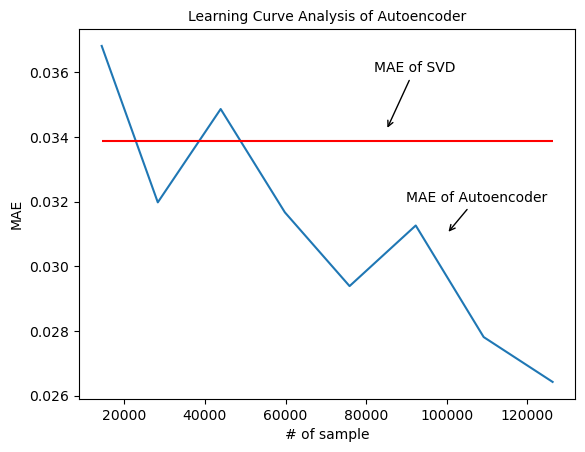

In [39]:
plt.plot(xx, yy)
plt.xlabel('# of sample')
plt.ylabel('MAE')
plt.title('Learning Curve Analysis of Autoencoder', fontsize=10)
plt.hlines(0.03385887335978506, min(xx),max(xx), colors='red')
plt.annotate(text='MAE of SVD', xy=(85000,0.0342), xytext=(82000,0.036), arrowprops=dict(arrowstyle="->"))
plt.annotate(text='MAE of Autoencoder', xy=(100000,0.031), xytext=(90000,0.032), arrowprops=dict(arrowstyle="->"))